In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
#Load dataset 
autotheft_df = pd.read_excel('autotheft_processed.xlsx')
autotheft_df. head()

,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,OCC_HOUR,DIVISION,HOOD_158,HOOD_140,LONG_WGS84,LAT_WGS84,REPORT_HOUR,LOCATION_ID,PREMISE_ID
0,20141708181,2014-03-15,2014-03-15,21,23,1,1,-79.604207,43.706027,21,23,6
1,20142063947,2014-05-12,2014-05-12,12,23,1,1,-79.604207,43.706027,12,23,6
2,20142095651,2014-05-17,2014-05-17,0,23,1,1,-79.604207,43.706027,4,23,6
3,20142573418,2014-07-26,2014-07-25,16,23,1,1,-79.604207,43.706027,1,23,6
4,20142573418,2014-07-26,2014-07-25,16,23,1,1,-79.604207,43.706027,1,23,6


# Data preprocessing

In [5]:
#Convert REPORT_DATE to datetime and resample the data to get monthly count of incidents
autotheft_df['OCC_DATE'] = pd.to_datetime(autotheft_df['OCC_DATE'])
# Set OCC_DATE as the index
autotheft_df.set_index('OCC_DATE', inplace=True)

# Resample to get monthly incident counts
monthly_incidents = autotheft_df.resample('M').size()

monthly_incidents.head(10)

OCC_DATE
2014-01-31    239
2014-02-28    232
2014-03-31    310
2014-04-30    301
2014-05-31    300
2014-06-30    256
2014-07-31    347
2014-08-31    339
2014-09-30    302
2014-10-31    356
Freq: M, dtype: int64

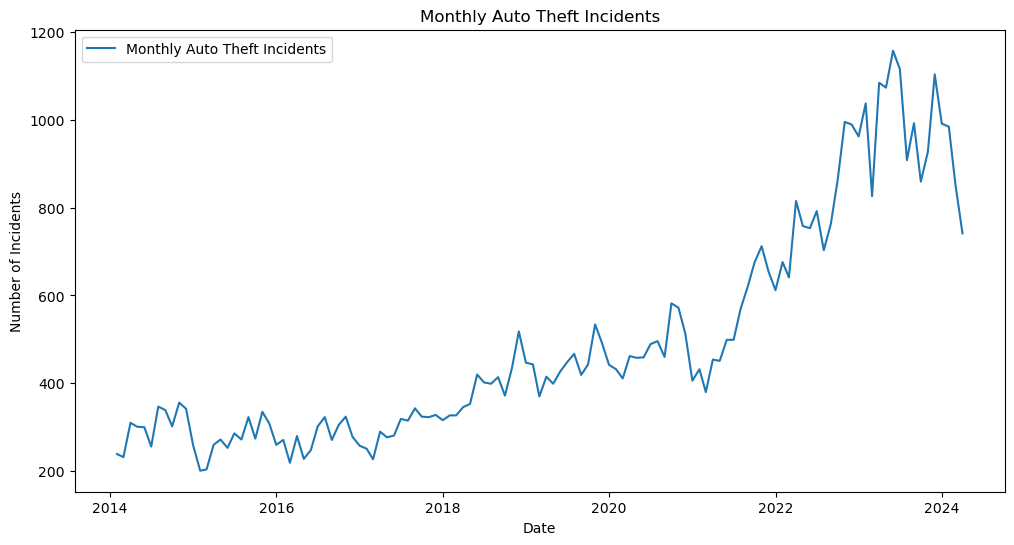

In [6]:
# Plot the monthly data
plt.figure(figsize=(12, 6))
plt.plot(monthly_incidents, label='Monthly Auto Theft Incidents')
plt.title('Monthly Auto Theft Incidents')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

# Check for Stationarity

ADF Statistic: -0.9390248761191629
p-value: 0.7748495461355315


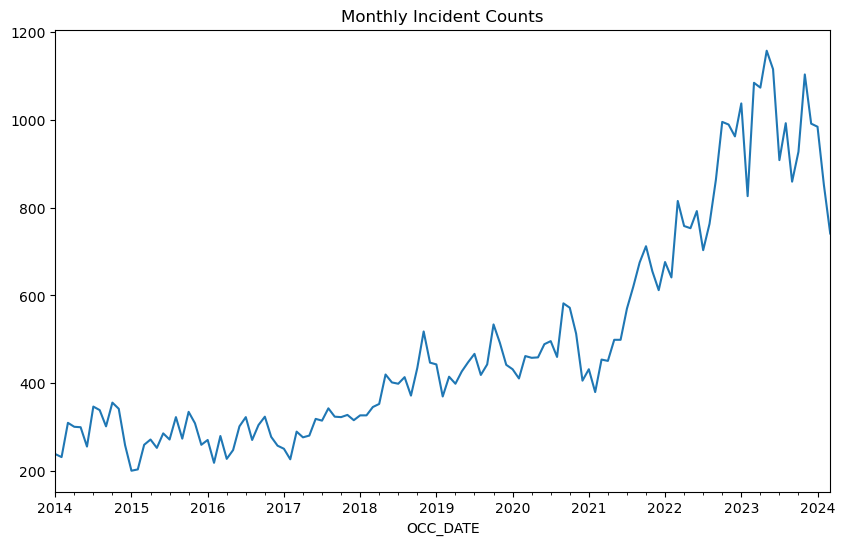

In [7]:
# Perform the ADF test
result = adfuller(monthly_incidents)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot the time series
monthly_incidents.plot(figsize=(10, 6), title='Monthly Incident Counts')
plt.show()

### The ADF test results show an ADF Statistic of -0.939 and a p-value of 0.775. Since the p-value is greater than 0.05, we fail to reject the null hypothesis, indicating that the time series is not stationary. To make the series stationary, we will difference the data.

ADF Statistic (Differenced): -2.3384956010191345
p-value (Differenced): 0.15985269716290162


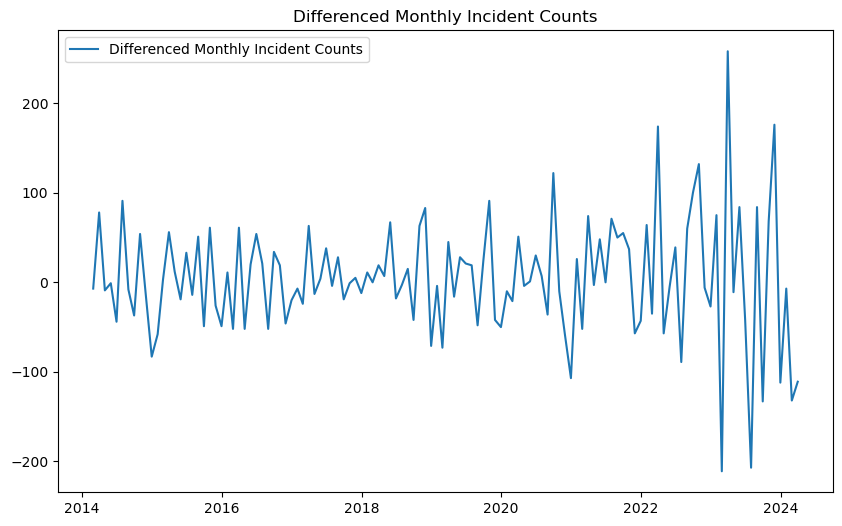

In [8]:
# First-order differencing
diff_monthly_incidents = monthly_incidents.diff().dropna()

# Perform the ADF test on the differenced data
result_diff = adfuller(diff_monthly_incidents)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(diff_monthly_incidents, label='Differenced Monthly Incident Counts')
plt.title('Differenced Monthly Incident Counts')
plt.legend()
plt.show()

### The ADF test results for the differenced data show an ADF Statistic of -2.338 and a p-value of 0.160. The p-value is still greater than 0.05, indicating that the time series is not yet stationary. Since the first differencing did not make the series stationary, we can try second-order differencing.


ADF Statistic (Second-order Differenced): -6.8504741413342165
p-value (Second-order Differenced): 1.6993844351415496e-09


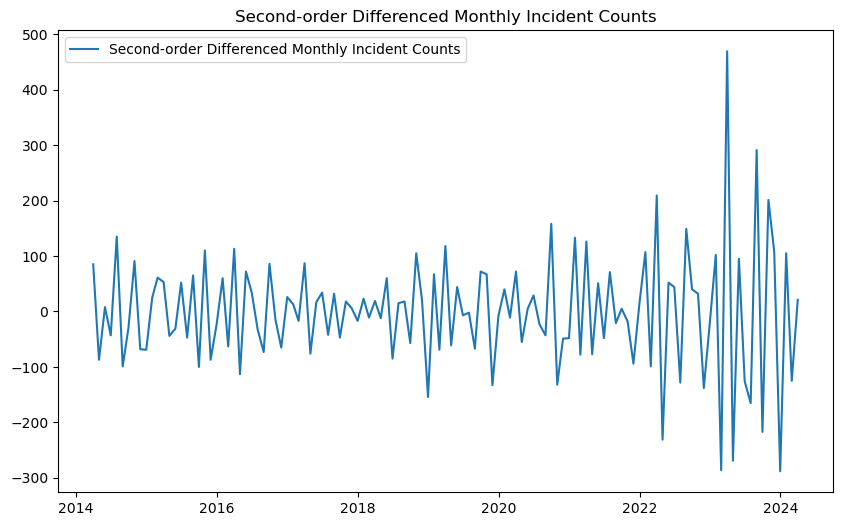

In [9]:
# Second-order differencing
diff2_monthly_incidents = diff_monthly_incidents.diff().dropna()

# Perform the ADF test on the second-order differenced data
result_diff2 = adfuller(diff2_monthly_incidents)
print('ADF Statistic (Second-order Differenced):', result_diff2[0])
print('p-value (Second-order Differenced):', result_diff2[1])

# Plot the second-order differenced time series
plt.figure(figsize=(10, 6))
plt.plot(diff2_monthly_incidents, label='Second-order Differenced Monthly Incident Counts')
plt.title('Second-order Differenced Monthly Incident Counts')
plt.legend()
plt.show()

### The ADF test results for the second-order differenced data show an ADF Statistic of -6.850 and a p-value of 1.7e-09. Since the p-value is significantly less than 0.05, we can reject the null hypothesis, indicating that the time series is now stationary.


# Determine parameters 

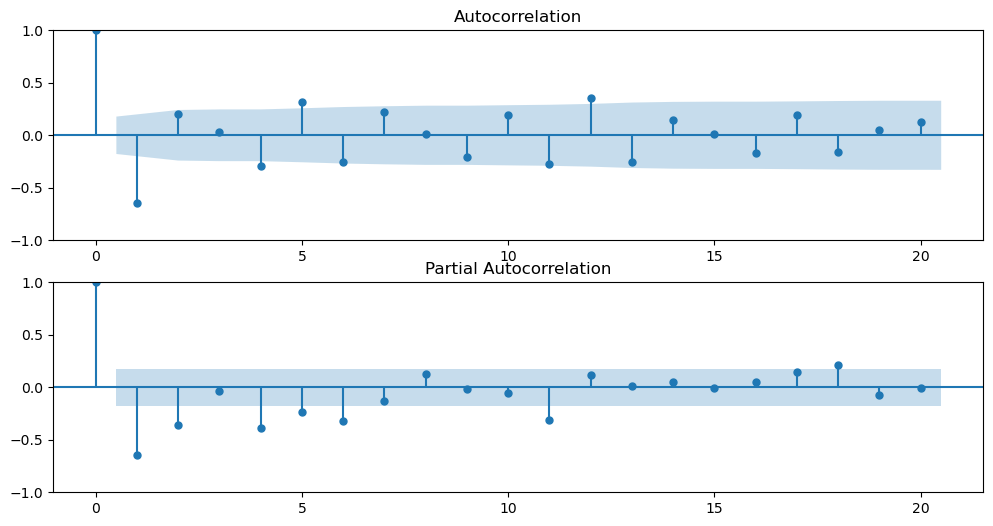

In [10]:
# Plot ACF and PACF for the second-order differenced data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff2_monthly_incidents, ax=plt.gca(), lags=20)
plt.subplot(212)
plot_pacf(diff2_monthly_incidents, ax=plt.gca(), lags=20)
plt.show()

### The ACF plot shows a significant spike at lag 1 and then cuts off, suggesting an MA(1) component. The PACF plot shows a significant spike at lag 1 and then cuts off, suggesting an AR(1) component. Based on these observations, we can start with an ARIMA(1, 2, 1) model.

In [11]:
# Split the data into train and validation sets
nValid = 24  # Last 24 months for validation
nTrain = len(monthly_incidents) - nValid
train_data = monthly_incidents[:nTrain]
valid_data = monthly_incidents[nTrain:]

In [12]:
# Fit ARIMA Model
arima_model = ARIMA(train_data, order=(1, 2, 1)).fit()
arima_forecast = arima_model.forecast(steps=nValid)

In [13]:
# Fit SARIMA Model
sarima_model = SARIMAX(train_data, order=(1, 2, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.forecast(steps=nValid)

In [14]:
# Fit Moving Average Model (Exponential Smoothing)
exp_smooth = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()
exp_smooth_forecast = exp_smooth.forecast(steps=nValid)

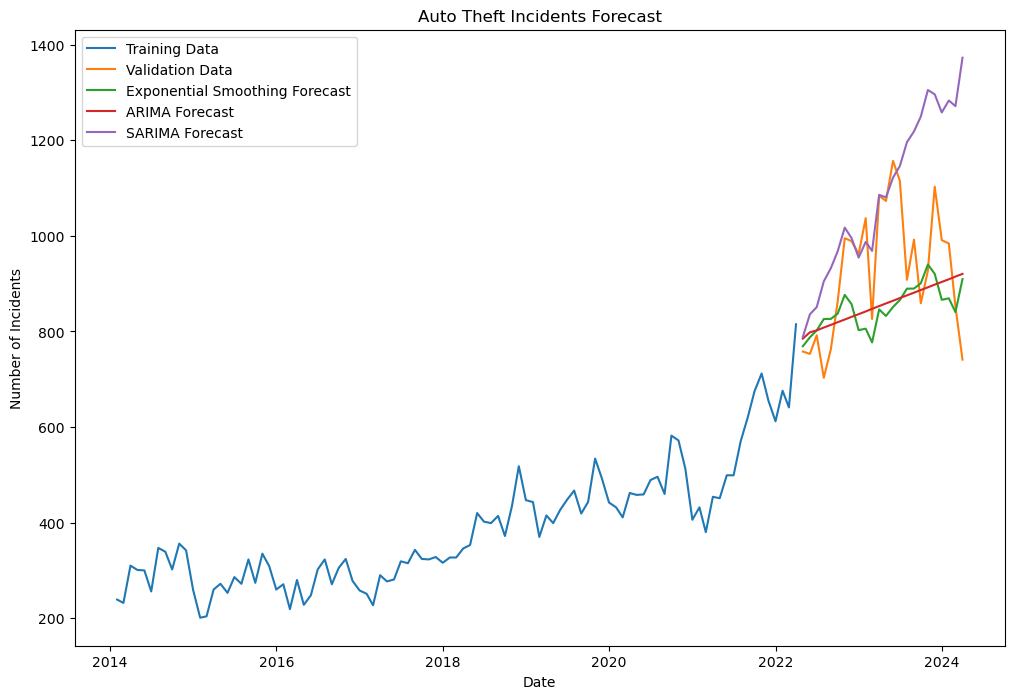

In [15]:
# Plot the results
plt.figure(figsize=(12, 8))

# Plot training data
plt.plot(train_data, label='Training Data')

# Plot validation data
plt.plot(valid_data, label='Validation Data')

# Plot forecasts
plt.plot(exp_smooth_forecast, label='Exponential Smoothing Forecast')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(sarima_forecast, label='SARIMA Forecast')

plt.title('Auto Theft Incidents Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

In [19]:
# Calculate MAPE for each model
def calculate_mape(forecast, actual):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Exponential Smoothing MAPE
exp_smooth_mape = calculate_mape(exp_smooth_forecast, valid_data)

# ARIMA MAPE
arima_mape = calculate_mape(arima_forecast, valid_data)

# SARIMA MAPE
sarima_mape = calculate_mape(sarima_forecast, valid_data)

# Print the MAPE values
print(f'ARIMA MAPE: {arima_mape}%')
print(f'SARIMA MAPE: {sarima_mape}%')
print(f'Exponential Smoothing MAPE: {exp_smooth_mape}%')

ARIMA MAPE: 11.750717306516856%
SARIMA MAPE: 19.50333150930601%
Exponential Smoothing MAPE: 11.784432072613809%


# Forecast

In [18]:
# Forecast future values for the next 12 months
future_steps = 12

# Exponential Smoothing future forecast
exp_smooth_future_forecast = exp_smooth.forecast(steps=future_steps)

# ARIMA future forecast
arima_future_forecast = arima_model.forecast(steps=future_steps)

# SARIMA future forecast
sarima_future_forecast = sarima_model.forecast(steps=future_steps)

# Create a date range for the future predictions
future_dates = pd.date_range(start='2024-03-01', periods=future_steps, freq='M')

# Create a DataFrame to display future predictions
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Exponential_Smoothing': exp_smooth_future_forecast,
    'ARIMA': arima_future_forecast,
    'SARIMA': sarima_future_forecast
})
# Display the future predictions
print(future_predictions)


                 Date  Exponential_Smoothing       ARIMA       SARIMA
2022-04-30 2024-03-31             768.952578  785.030178   788.428213
2022-05-31 2024-04-30             787.759517  798.168080   835.911777
2022-06-30 2024-05-31             802.286355  802.195439   851.007024
2022-07-31 2024-06-30             826.039278  808.148253   904.859054
2022-08-31 2024-07-31             826.212419  813.694134   932.449354
2022-09-30 2024-08-31             837.296548  819.326018   967.803787
2022-10-31 2024-09-30             876.519219  824.939726  1017.270332
2022-11-30 2024-10-31             857.022144  830.557275   995.234666
2022-12-31 2024-11-30             802.688969  836.174013   954.567453
2023-01-31 2024-12-31             805.864540  841.790922   987.410567
2023-02-28 2025-01-31             776.972356  847.407794   968.507125
2023-03-31 2025-02-28             846.092875  853.024675  1085.762238


## Side notes: Explaination for decision on the test periods 12months, 24 months, or 36 months

In [21]:
def evaluate_models(data, test_period):
    # Split the data into train and validation sets
    nValid = test_period
    nTrain = len(data) - nValid
    train_data = data[:nTrain]
    valid_data = data[nTrain:]
# Fit Moving Average Model (Exponential Smoothing)
    exp_smooth = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit()
    exp_smooth_forecast = exp_smooth.forecast(steps=nValid)

    # Fit ARIMA Model
    arima_model = ARIMA(train_data, order=(1, 2, 1)).fit()
    arima_forecast = arima_model.forecast(steps=nValid)

    # Fit SARIMA Model
    sarima_model = SARIMAX(train_data, order=(1, 2, 1), seasonal_order=(1, 1, 1, 12)).fit()
    sarima_forecast = sarima_model.forecast(steps=nValid)

    # Define the function to calculate MAPE
    def calculate_mape(actual, forecast):
        return np.mean(np.abs((actual - forecast) / actual)) * 100
    
    exp_smooth_mape = calculate_mape(exp_smooth_forecast, valid_data)
    arima_mape = calculate_mape(arima_forecast, valid_data)
    sarima_mape = calculate_mape(sarima_forecast, valid_data)

    print(f'ARIMA MAPE (Test Period: {test_period}): {arima_mape}%')
    print(f'SARIMA MAPE (Test Period: {test_period}): {sarima_mape}%')
    print(f'Exponential Smoothing MAPE (Test Period: {test_period}): {exp_smooth_mape}%')
    
    # Evaluate models with different test periods
for test_period in [12, 24, 36]:
    evaluate_models(monthly_incidents, test_period)

ARIMA MAPE (Test Period: 12): 14.091658577673405%
SARIMA MAPE (Test Period: 12): 18.172064440849798%
Exponential Smoothing MAPE (Test Period: 12): 18.18949140800516%
ARIMA MAPE (Test Period: 24): 13.329143378224448%
SARIMA MAPE (Test Period: 24): 14.309027501962232%
Exponential Smoothing MAPE (Test Period: 24): 13.548074131649543%
ARIMA MAPE (Test Period: 36): 68.70301579526028%
SARIMA MAPE (Test Period: 36): 66.0377066514922%
Exponential Smoothing MAPE (Test Period: 36): 64.53817388748391%
